In [1]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import pickle
from DataLoader import load_data
from sklearn.utils import shuffle


Removing trolls, shreks and duplicates


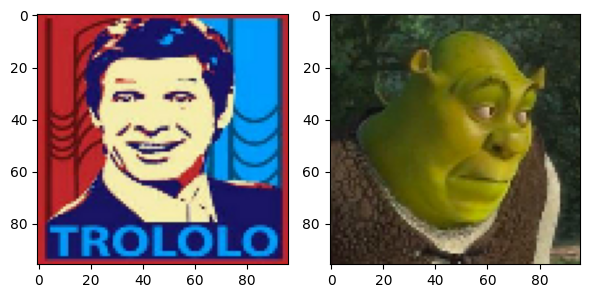

Removed Images: 350


In [4]:
# Load data. This function also cleans the data and splits it into train, test and validation sets. In this case we are letting the method split for
# test and validation sets because we first want to create a balanced datatest.
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_data(test_size=0, val_size=0.0, seed=seed)

In [6]:
# Create balanced dataset

mask = y_train == 0
X_train_neg = X_train[mask]
X_train_pos = X_train[~mask]
y_train_neg = y_train[mask]
y_train_pos = y_train[~mask]

In [7]:
mask_index = random.sample(range(len(X_train_neg)), len(X_train_pos))
mask = np.zeros(len(X_train_neg), dtype=bool)
mask[mask_index] = True
X_train_neg = X_train_neg[mask]
y_train_neg = y_train_neg[mask]

In [8]:
X_train_equal = np.concatenate((X_train_pos, X_train_neg))
y_train_equal = np.concatenate((y_train_pos, y_train_neg))

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(
#        X_train_equal, y_train_equal, random_state=seed, test_size=0.2, stratify=y_train_equal, shuffle=True)

In [10]:
X_train, y_train = shuffle(X_train_equal, y_train_equal)

In [11]:
# Low augmentation
data_augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomRotation(0.2),
])

# Heavier augmentation
heavy_data_augmentation = tfk.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(0.5),
])

In [12]:
# Function for creating the base transfer learning XCeption model
def getXceptionModel_TL(data_augmentation):
    #Retrieve base model
    base_model = tfk.applications.Xception(
        input_shape=(96, 96, 3),
        include_top=False,
        weights="imagenet",
    )
    base_model.trainable = False

    # Add input layer and preprocess input as indicated in keras docs for this specific model
    inputs = tfk.Input(shape=(96, 96, 3))
    x = data_augmentation(inputs)
    scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
    x = scale_layer(x)

    x = base_model(x, training=False)

    # Add pooling layer, dropout for regularization and output layer
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.2)(x)
    output = tfkl.Dense(1)(x)

    model = tfk.Model(inputs, output)
    # Compile model
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])

    return model

In [13]:
# Function for creating setting the tuning XCeption model.
# The model is set to retrain from the 6th layer to the end while freezing the first 5 layers.
def getXceptionModel_FT_6(model: tfk.Model):
    from_layer_reversed = 80
    base_model = model.get_layer("xception")

    base_model.trainable = True
    
    print("Training from layer: ", base_model.layers[(len(base_model.layers)-from_layer_reversed)].name)
    for layer in base_model.layers[:(len(base_model.layers)-from_layer_reversed)]:
        layer.trainable = False
    
    for layer in base_model.layers[(len(base_model.layers)-from_layer_reversed):]:
        layer.trainable = True
        
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
    return model

In [14]:
# Function for creating setting the tuning XCeption model.
# The model is set to retrain from the 10th layer to the end while freezing the first 9 layers.
def getXceptionModel_FT_10(model: tfk.Model):
    from_layer_reversed = 40
    base_model = model.get_layer("xception")
    
    base_model.trainable = True

    print("Training from layer: ", base_model.layers[(len(base_model.layers)-from_layer_reversed)].name)
    for layer in base_model.layers[:(len(base_model.layers)-from_layer_reversed)]:
        layer.trainable = False
    
    for layer in base_model.layers[(len(base_model.layers)-from_layer_reversed):]:
        layer.trainable = True
        
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
    return model

In [15]:
# Function for creating setting the tuning XCeption model.
# The model is set to retrain from the 13th layer to the end while freezing the first 12 layers.
def getXceptionModel_FT_13(model: tfk.Model):
    from_layer_reversed = 16
    base_model = model.get_layer("xception")
    
    base_model.trainable = True

    print("Training from layer: ", base_model.layers[(len(base_model.layers)-from_layer_reversed)].name)
    for layer in base_model.layers[:(len(base_model.layers)-from_layer_reversed)]:
        layer.trainable = False
    
    for layer in base_model.layers[(len(base_model.layers)-from_layer_reversed):]:
        layer.trainable = True
        
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
    return model

In [16]:
# Function for creating setting the tuning XCeption model.
# The model is set to retrain all of the layers.
def getXceptionModel_FT_FULL(model: tfk.Model):
    base_model = model.get_layer("xception")

    base_model.trainable = True
        
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
    return model

In [17]:
#Not used
def getVGG16_TL(data_augmentation):
    base_model = tfk.applications.VGG19(
        input_shape=(96, 96, 3),
        include_top=False,
        weights="imagenet",
        pooling='none'
    )

    base_model.trainable = False
    
    inputs = tfk.Input(shape=(96, 96, 3))
    x = data_augmentation(inputs)
    scale_layer = tfkl.Rescaling(scale = 1/127.5, offset=-1)
    x = scale_layer(x)

    x = base_model(x, training=False)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.2)(x)

    output = tfkl.Dense(2, activation="softmax")(x)
    model = tfk.Model(inputs, output)
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    return model

In [18]:
# Function for creating the base transfer learning ConvNextTiny model
def getConvNet_TL(data_augmentation):
    #Retrieve base model
    base_model = tfk.applications.ConvNeXtTiny(
        model_name="convnext_tiny",
        input_shape=(96, 96, 3),
        include_top=False,
        include_preprocessing=True,
        weights="imagenet",
        pooling='none'
    )

    base_model.trainable = False
    
    # Add input layer. Preprocessing layer is not needed as ConvNextTiny expects input in range [0, 255]
    inputs = tfk.Input(shape=(96, 96, 3))
    x = data_augmentation(inputs)

    x = base_model(x, training=False)

    # Add pooling layer, dropout for regularization and output layer
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(0.2)(x)
    output = tfkl.Dense(1)(x)
    
    model = tfk.Model(inputs, output)
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])

    return model


In [19]:
# Function for creating setting the tuning ConvNetTiny model.
# The model is set to retrain all of the layers.
def getConvNet_FT(model: tfk.Model):
    base_model = model.get_layer("convnext_tiny")

    base_model.trainable = True
        
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
    return model

In [20]:
# Function for creating setting the tuning ConvNetTiny model.
# The model is set to retrain from the 10th layer to the end while freezing the first 9 layers.
def getConvNet_FT_10(model: tfk.Model):
    base_model = model.get_layer("convnext_tiny")

    base_model.trainable = True

    for layer in base_model.layers[:92]:
        layer.trainable = False
    
    for layer in base_model.layers[92:]:
        layer.trainable = True
        
    model.compile(loss=tfk.losses.BinaryCrossentropy(from_logits=True), optimizer=tfk.optimizers.Adam(1e-5), metrics=[tfk.metrics.BinaryAccuracy(), tfk.metrics.Precision(), tfk.metrics.Recall()])
    return model

In [21]:
# List of models to train and validate
models_to_validate = [
    ("ConvNetTiny_EQ", getConvNet_TL(data_augmentation), getConvNet_FT),
    ("ConvNetTiny_10", getConvNet_TL(data_augmentation), getConvNet_FT_10),
    ("ConvNetTiny_HeavyAug_EQ_FULL", getConvNet_TL(heavy_data_augmentation), getConvNet_FT),
    ("ConvNetTiny_Full_10_HeavyAug", getConvNet_TL(heavy_data_augmentation), getConvNet_FT_10),
    ("XCeption_FULL", getXceptionModel_TL(heavy_data_augmentation), getXceptionModel_FT_FULL),
    ("XCeption_13", getXceptionModel_TL(heavy_data_augmentation), getXceptionModel_FT_10),
    ("XCeption_10", getXceptionModel_TL(heavy_data_augmentation), getXceptionModel_FT_10),
    ("XCeption_6", getXceptionModel_TL(heavy_data_augmentation), getXceptionModel_FT_6),
]

In [22]:
histories = []

In [23]:
for model_name, model, model_ft_fun in models_to_validate:
    #Transfer learning of the model
    print("Transfer Learning | Training model: ", model_name)
    tl_history = model.fit(
        X_train, y_train,
        batch_size = 32,
        epochs = 30,
        validation_data = (X_test, y_test),
        callbacks = [tfk.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=20, restore_best_weights=True)]
    ).history

    print("Fine Tuning | Training model: ", model_name)
    model = model_ft_fun(model)

    #Fine tuning of the model
    ft_history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = 32,
        epochs = 40,
        validation_data = (X_test, y_test),
        callbacks = [tfk.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=20, restore_best_weights=True)]
    ).history

    #Saving history and model

    model.save(model_name)

    del model

    with open(f'{model_name}_tl_history', 'wb') as file_pi:
        pickle.dump(tl_history, file_pi)
    with open(f'{model_name}_ft_history', 'wb') as file_pi:
        pickle.dump(ft_history, file_pi)

    histories.append((model_name, tl_history, ft_history))

Transfer Learning | Training model:  XCeption_FULL
Epoch 1/30
90/90 [==============================] - 13s 93ms/step - loss: 0.6502 - binary_accuracy: 0.5688 - precision: 0.7109 - recall: 0.2318 - val_loss: 0.5999 - val_binary_accuracy: 0.6034 - val_precision: 0.8190 - val_recall: 0.2654
Epoch 2/30
90/90 [==============================] - 5s 58ms/step - loss: 0.5946 - binary_accuracy: 0.6421 - precision: 0.7761 - recall: 0.3994 - val_loss: 0.6144 - val_binary_accuracy: 0.6047 - val_precision: 0.8571 - val_recall: 0.2514
Epoch 3/30
90/90 [==============================] - 5s 58ms/step - loss: 0.5733 - binary_accuracy: 0.6746 - precision: 0.8056 - recall: 0.4602 - val_loss: 0.5685 - val_binary_accuracy: 0.6550 - val_precision: 0.8447 - val_recall: 0.3799
Epoch 4/30
90/90 [==============================] - 5s 56ms/step - loss: 0.5538 - binary_accuracy: 0.6868 - precision: 0.8057 - recall: 0.4923 - val_loss: 0.5831 - val_binary_accuracy: 0.6397 - val_precision: 0.8521 - val_recall: 0.3380


In [76]:
models_to_graph = [
    ["XCeption_FULL", "binary_accuracy", "precision_4", "recall_4"],
    ["XCeption_13", "binary_accuracy", "precision_5", "recall_5"],
    ["XCeption_10", "binary_accuracy", "precision_6", "recall_6"],
    ["XCeption_6", "binary_accuracy", "precision_7", "recall_7"],
    #ConvNet
    ["ConvNetTiny", "binary_accuracy", "precision_4", "recall_4"],
    ["ConvNetTiny_10", "binary_accuracy", "precision_5", "recall_5"],
    ["ConvNetTiny_EQ", "binary_accuracy", "precision_2", "recall_2"],
    ["ConvNetTiny_HeavyAug_EQ", "binary_accuracy", "precision_3", "recall_3"],
]

In [77]:
#Function for graphing accuracy, precision and recall of the models
def graph_histroy(models_data):
    for model_data in models_data:
        r = random.random() 
        b = random.random() 
        g = random.random() 
        model_color = (r, g, b)
        model_data.insert(0, model_color)

    #Model_data = (color, history, model_name, accuracy, precision, recall)

    #Accuracy
    plt.figure(figsize=(10,5))
    for model_data in models_data:
        label = model_data[2] if "XCeption" not in model_data[2] else model_data[2] + "_EQ"
        plt.plot(model_data[1]['val_'+model_data[3]][0:40], label=label, color=model_data[0], alpha=.8)
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    #Precision
    plt.figure(figsize=(10,5))
    for model_data in models_data:
        label = model_data[2] if "XCeption" not in model_data[2] else model_data[2] + "_EQ"
        plt.plot(model_data[1]['val_'+model_data[4]][0:40], label=label, color=model_data[0], alpha=.8)
    plt.legend(loc='upper left')
    plt.title('Precision')
    plt.grid(alpha=.3)

    #Recall
    plt.figure(figsize=(10,5))
    for model_data in models_data:
        label = model_data[2] if "XCeption" not in model_data[2] else model_data[2] + "_EQ"
        plt.plot(model_data[1]['val_'+model_data[5]][0:40], label=label, color=model_data[0], alpha=.8)
    plt.legend(loc='upper left')
    plt.title('Recall')
    plt.grid(alpha=.3)

    plt.show()

In [78]:
def graph_history_file(models_data):
    for model_data in models_data:
        print(model_data)
        with open(model_data[0] +  "_ft_history", 'rb') as file_pi:
            history = pickle.load(file_pi)
            model_data.insert(0, history)

    graph_histroy(models_data)

[['XCeption_FULL', 'binary_accuracy', 'precision_4', 'recall_4'], ['XCeption_13', 'binary_accuracy', 'precision_5', 'recall_5'], ['XCeption_10', 'binary_accuracy', 'precision_6', 'recall_6'], ['XCeption_6', 'binary_accuracy', 'precision_7', 'recall_7'], ['ConvNetTiny', 'binary_accuracy', 'precision_4', 'recall_4'], ['ConvNetTiny_10', 'binary_accuracy', 'precision_5', 'recall_5'], ['ConvNetTiny_EQ', 'binary_accuracy', 'precision_2', 'recall_2'], ['ConvNetTiny_HeavyAug_EQ', 'binary_accuracy', 'precision_3', 'recall_3']]
['XCeption_FULL', 'binary_accuracy', 'precision_4', 'recall_4']
['XCeption_13', 'binary_accuracy', 'precision_5', 'recall_5']
['XCeption_10', 'binary_accuracy', 'precision_6', 'recall_6']
['XCeption_6', 'binary_accuracy', 'precision_7', 'recall_7']
['ConvNetTiny', 'binary_accuracy', 'precision_4', 'recall_4']
['ConvNetTiny_10', 'binary_accuracy', 'precision_5', 'recall_5']
['ConvNetTiny_EQ', 'binary_accuracy', 'precision_2', 'recall_2']
['ConvNetTiny_HeavyAug_EQ', 'binary

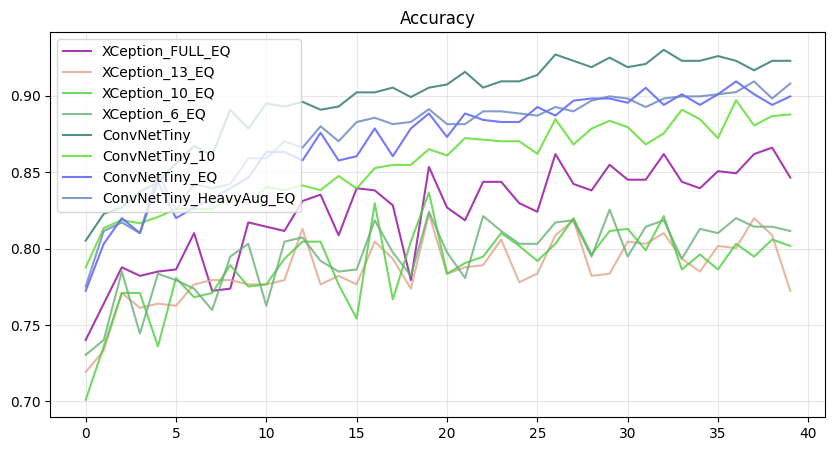

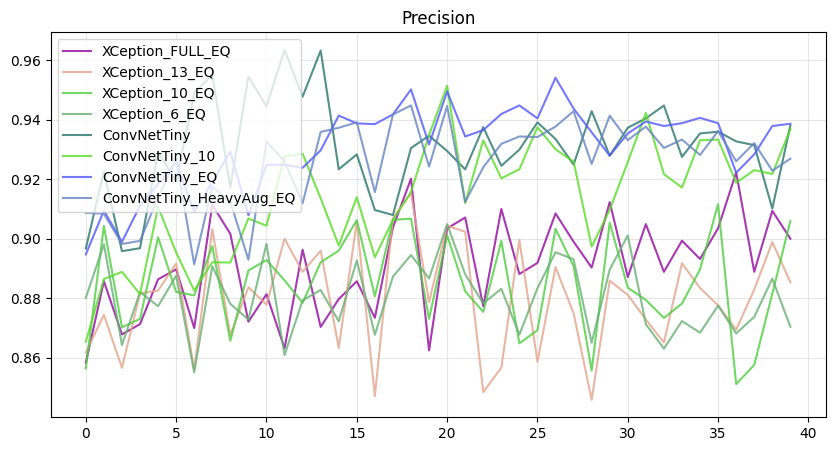

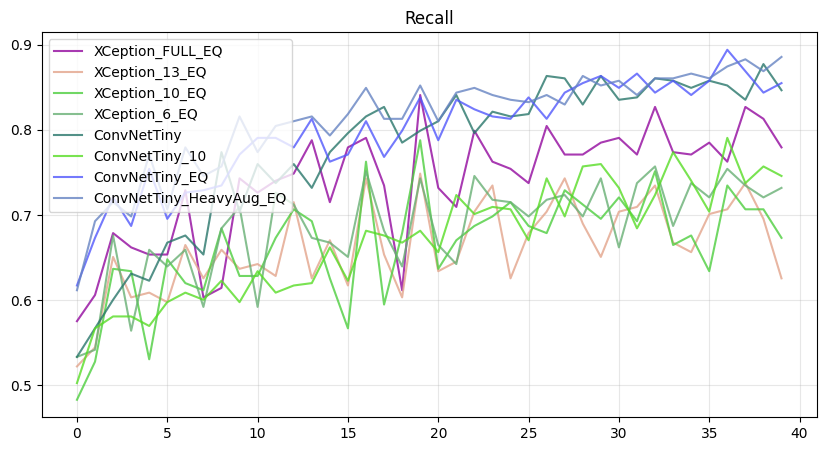

In [79]:
graph_history_file(models_to_graph)